### **Modelling stock price data**

##### **Model SPY yearly data**

Model SPY yearly price change data with macroeconomic features: emplyment, interest rates, house prices, consumer prices, credit etc.

While correlation does not necessarly mean causation, modelling price change and finding the feature weights can give us an idea of how the stock market moves.

Data:
1. Yahoo finance SPY price change
1. Bank if international settlements webpage [BIS](www.bis.org)

##### **Model Quarterly stock data**

We will model stock price data (log price or percentage change) using quarterly net earnings, US policy rates, property prices and employment data.

Before modelling, we will do some data validation to understand the distribution of each feature and their relationship with the dependent variable.

We will use the following models:

1. Basic multivariate regression model
2. GAM to model the non-linear relationships between independent and dependent variables
3. Bayesian model 

Stocks to model: MSFT, BAC

In [40]:
# Data manipulation
import numpy as np
import pandas as pd

import functools as ft

import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
# load data 
df_spy = pd.read_csv('./data/SPY.csv') # monthly SPY data
df_cp = pd.read_excel('./data/consumer_prices.xlsx', sheet_name='data') # consumer prices, monthly
df_pp = pd.read_excel('./data/properties_prices.xlsx', sheet_name='data') # properity prices, quarterly
df_ir = pd.read_excel('./data/interest_rates.xlsx', sheet_name='monthly') # interest rates, monthly
df_tc = pd.read_excel('./data/totcredit.xlsx', sheet_name='quarterly_data') # total credit, quarterly
df_nfp = pd.read_excel('./data/nfp_total.xlsx') # nfp employment data, monthly

### Preparing data

##### Consumer Price data

In [42]:
df_cp = df_cp.set_index('Period')
df_cp = df_cp.resample('Q').ohlc()

In [43]:
df_cp.head()

US                               Euro               
                open      high       low     close open high low close
Period                                                                
1914-03-31  2.040816  2.040816  1.020408  1.020408  NaN  NaN NaN   NaN
1914-06-30  0.000000  2.061856  0.000000  1.020408  NaN  NaN NaN   NaN
1914-09-30  1.010101  3.030303  1.010101  2.000000  NaN  NaN NaN   NaN
1914-12-31  1.000000  1.000000  0.990099  1.000000  NaN  NaN NaN   NaN
1915-03-31  1.000000  1.010101  0.000000  0.000000  NaN  NaN NaN   NaN

In [44]:
df_cp = df_cp['US'].reset_index()
df_cp = df_cp[['close', 'Period']].rename(columns={'close':'us_cp'})

In [45]:
df_cp["date"] = df_cp['Period'].apply(lambda dt: dt.replace(day=1))
df_cp.drop(['Period'], axis=1, inplace=True)
df_cp.head()

,us_cp,date
0,1.020408,1914-03-01
1,1.020408,1914-06-01
2,2.000000,1914-09-01
3,1.000000,1914-12-01
4,0.000000,1915-03-01


##### Total credit

In [46]:
df_tc["date"] = df_tc['Period'].apply(lambda dt: dt.replace(day=1))
df_tc.drop(['Period'], axis=1, inplace=True)
df_tc = df_tc[['US', 'date']]
df_tc.rename(columns={'US':'us_tc'}, inplace=True)
df_tc.head()

,us_tc,date
0,353.722,1945-12-01
1,354.332,1946-03-01
2,350.867,1946-06-01
3,346.826,1946-09-01
4,345.682,1946-12-01


##### NFP

In [47]:
df_nfp_melt = pd.melt(df_nfp, id_vars=['Year'], value_vars=df_nfp.columns, var_name='month', value_name='nfp')
df_nfp_melt.head()

,Year,month,nfp
0,1980,Jan,90800.0
1,1981,Jan,91033.0
2,1982,Jan,90565.0
3,1983,Jan,88990.0
4,1984,Jan,92673.0


In [48]:
df_nfp_melt['date_month'] = df_nfp_melt.Year.astype('str') + "-" + df_nfp_melt.month.astype('str') 

In [49]:
df_nfp_melt['date_month'] = pd.to_datetime(df_nfp_melt['date_month'])
df_nfp_melt.drop(['Year', 'month'], axis=1, inplace=True)
df_nfp_melt.head()

,nfp,date_month
0,90800.0,1980-01-01
1,91033.0,1981-01-01
2,90565.0,1982-01-01
3,88990.0,1983-01-01
4,92673.0,1984-01-01


In [50]:
df_nfp_melt = df_nfp_melt.set_index('date_month')
df_nfp_melt = df_nfp_melt.resample('Q').ohlc()

In [51]:
df_nfp_melt = df_nfp_melt['nfp'].reset_index()
df_nfp_melt = df_nfp_melt[['close', 'date_month']].rename(columns={'close':'nfp'})

In [52]:
df_nfp_melt["date"] = df_nfp_melt['date_month'].apply(lambda dt: dt.replace(day=1))
df_nfp_melt.drop(['date_month'], axis=1, inplace=True)
df_nfp_melt.head()

,nfp,date
0,90994.0,1980-03-01
1,90101.0,1980-06-01
2,90213.0,1980-09-01
3,90943.0,1980-12-01
4,91210.0,1981-03-01


##### Property Prices

In [53]:
df_pp.head()

,Period,EXISTNG_DWELLINGS,EXIST.1-FAMILY_HOUSES,NEW 1-FAMILY_HOUSES,Euro
0,1963-03-31,NaN,NaN,11.7,NaN
1,1963-06-30,NaN,NaN,11.6,NaN
2,1963-09-30,NaN,NaN,11.5,NaN
3,1963-12-31,NaN,NaN,11.7,NaN
4,1964-03-31,NaN,NaN,11.5,NaN


In [54]:
df_pp["date"] = df_pp['Period'].apply(lambda dt: dt.replace(day=1))
df_pp.drop(['Period', 'Euro', 'EXIST.1-FAMILY_HOUSES', 'EXISTNG_DWELLINGS'], axis=1, inplace=True)
df_pp.head()

,EXISTNG_DWELLINGS,EXIST.1-FAMILY_HOUSES,NEW 1-FAMILY_HOUSES,date
0,NaN,NaN,11.7,1963-03-01
1,NaN,NaN,11.6,1963-06-01
2,NaN,NaN,11.5,1963-09-01
3,NaN,NaN,11.7,1963-12-01
4,NaN,NaN,11.5,1964-03-01


##### Interest Rates

In [55]:
df_ir.head()

,Period,US,Euro
0,1954-07-31,0.25,NaN
1,1954-08-31,1.44,NaN
2,1954-09-30,1.44,NaN
3,1954-10-31,1.13,NaN
4,1954-11-30,1.38,NaN


In [56]:
df_ir = df_ir.set_index('Period')
df_ir = df_ir.resample('Q').ohlc()

In [57]:
df_ir = df_ir['US'].reset_index()
df_ir = df_ir[['close', 'Period']].rename(columns={'close':'us_ir'})

In [58]:
df_ir["date"] = df_ir['Period'].apply(lambda dt: dt.replace(day=1))
df_ir.drop(['Period'], axis=1, inplace=True)
df_ir.head()

,us_ir,date
0,1.44,1954-09-01
1,1.44,1954-12-01
2,1.44,1955-03-01
3,1.69,1955-06-01
4,2.19,1955-09-01


##### SPY data

In [59]:
df_spy.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-02-01,43.96875,45.12500,42.81250,44.40625,25.709480,5417600
1,1993-03-01,44.56250,45.84375,44.21875,45.18750,26.161797,3019200
2,1993-04-01,45.25000,45.25000,43.28125,44.03125,25.612766,2697200
3,1993-05-01,44.09375,45.65625,43.84375,45.21875,26.303528,1808000
4,1993-06-01,45.37500,45.81250,44.21875,45.06250,26.212654,3438000


In [60]:
df_spy['Date'] = pd.to_datetime(df_spy['Date'])

In [61]:
df_spy_price = df_spy[['Date', 'Adj Close']]
df_spy_vol = df_spy[['Date', 'Volume']]

In [62]:
df_spy_price = df_spy_price.set_index('Date')
df_spy_price = df_spy_price.resample('Q').ohlc()

In [63]:
df_spy_price.head()

Adj Close                                 
                 open       high        low      close
Date                                                  
1993-03-31  25.709480  26.161797  25.709480  26.161797
1993-06-30  25.612766  26.303528  25.612766  26.212654
1993-09-30  26.270269  27.277155  26.270269  26.911003
1993-12-31  27.612890  27.612890  27.318153  27.465502
1994-03-31  28.617989  28.617989  26.466524  26.466524

In [64]:
df_spy_vol = df_spy_vol.set_index('Date')
df_spy_vol = df_spy_vol.resample('Q').sum()

In [65]:
df_spy_vol.head()

,Volume
Date,
1993-03-31,8436800
1993-06-30,7943200
1993-09-30,15927600
1993-12-31,18452000
1994-03-31,32517000


In [66]:
df_spy_price = df_spy_price['Adj Close'].reset_index()
df_spy_price = df_spy_price[['close', 'Date']].rename(columns={'close':'spy_close'})


In [67]:
df_spy_vol = df_spy_vol['Volume'].reset_index()
df_spy_vol = df_spy_vol[['Volume', 'Date']].rename(columns={'Volume':'spy_vol'})

In [68]:
df_spy_price["date"] = df_spy_price['Date'].apply(lambda dt: dt.replace(day=1))
df_spy_price.drop(['Date'], axis=1, inplace=True)
df_spy_price.head()

,spy_close,date
0,26.161797,1993-03-01
1,26.212654,1993-06-01
2,26.911003,1993-09-01
3,27.465502,1993-12-01
4,26.466524,1994-03-01


In [69]:
df_spy_vol["date"] = df_spy_vol['Date'].apply(lambda dt: dt.replace(day=1))
df_spy_vol.drop(['Date'], axis=1, inplace=True)
df_spy_vol.head()

,spy_vol,date
0,8436800,1993-03-01
1,7943200,1993-06-01
2,15927600,1993-09-01
3,18452000,1993-12-01
4,32517000,1994-03-01


In [70]:
df_spy_total = pd.merge(df_spy_price, df_spy_vol, on='date')

### Join all data into a master dataframe

In [77]:
dfs = [df_spy_total, df_ir, df_nfp_melt, df_cp, df_pp, df_tc]
X = ft.reduce(lambda left, right: pd.merge(left, right, how='left' ,on='date'), dfs)

In [78]:
X.head()

,spy_close,date,spy_vol,us_ir,nfp,us_cp,EXISTNG_DWELLINGS,EXIST.1-FAMILY_HOUSES,NEW 1-FAMILY_HOUSES,us_tc
0,26.161797,1993-03-01,8436800,3.0,109994.0,3.086863,75.401,175.70,57.9,12307.791
1,26.212654,1993-06-01,7943200,3.0,110749.0,2.995720,75.718,177.39,59.9,12540.492
2,26.911003,1993-09-01,15927600,3.0,111448.0,2.689314,76.259,178.82,59.7,12784.982
3,27.465502,1993-12-01,18452000,3.0,112314.0,2.748414,76.922,180.29,59.6,12947.953
4,26.466524,1994-03-01,32517000,3.5,113242.0,2.506964,77.250,181.42,62.4,12941.752


In [79]:
# prepareing spy close data:
X['spy_close'] = np.log1p(X.spy_close.pct_change())


In [80]:
X.head()

,spy_close,date,spy_vol,us_ir,nfp,us_cp,EXISTNG_DWELLINGS,EXIST.1-FAMILY_HOUSES,NEW 1-FAMILY_HOUSES,us_tc
0,NaN,1993-03-01,8436800,3.0,109994.0,3.086863,75.401,175.70,57.9,12307.791
1,0.001942,1993-06-01,7943200,3.0,110749.0,2.995720,75.718,177.39,59.9,12540.492
2,0.026293,1993-09-01,15927600,3.0,111448.0,2.689314,76.259,178.82,59.7,12784.982
3,0.020396,1993-12-01,18452000,3.0,112314.0,2.748414,76.922,180.29,59.6,12947.953
4,-0.037050,1994-03-01,32517000,3.5,113242.0,2.506964,77.250,181.42,62.4,12941.752


### Data Validation

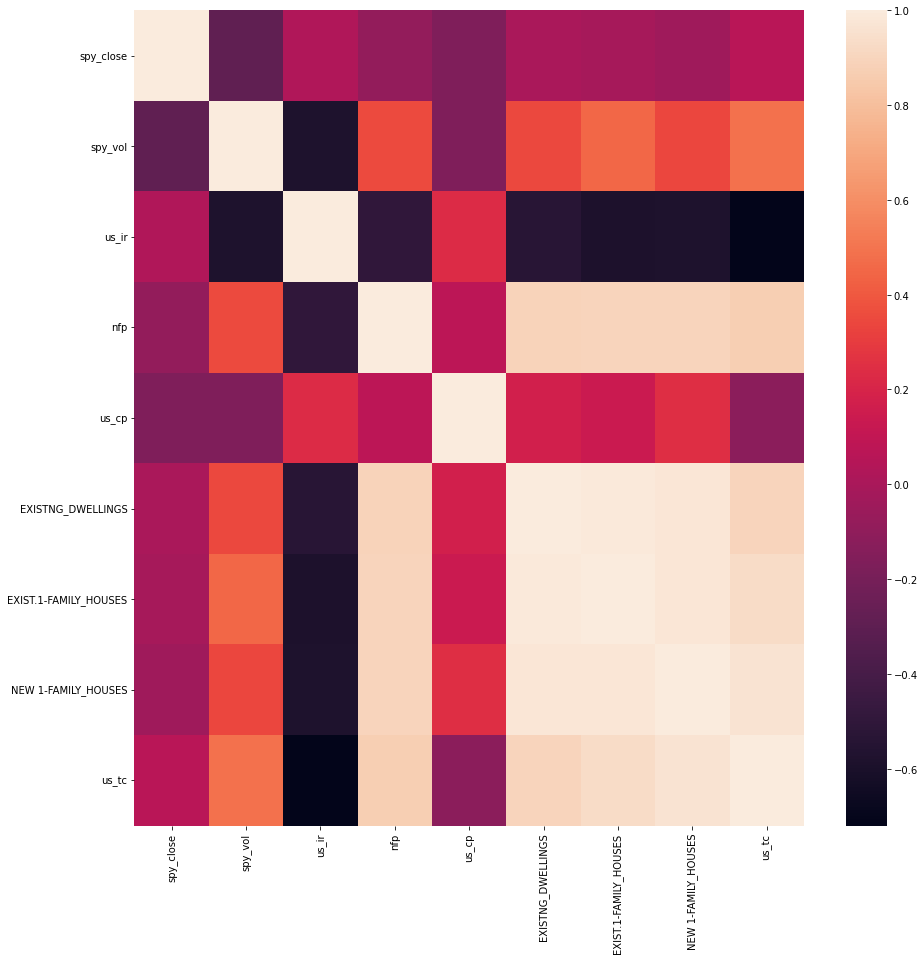

In [81]:
ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(X.corr())
plt.show()

In [82]:
cor_matrix = X.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
print(upper_tri)

                       spy_close   spy_vol     us_ir       nfp     us_cp  \
spy_close                    NaN  0.290626  0.026633  0.083990  0.164466   
spy_vol                      NaN       NaN  0.585885  0.348987  0.167846   
us_ir                        NaN       NaN       NaN  0.500664  0.228667   
nfp                          NaN       NaN       NaN       NaN  0.073194   
us_cp                        NaN       NaN       NaN       NaN       NaN   
EXISTNG_DWELLINGS            NaN       NaN       NaN       NaN       NaN   
EXIST.1-FAMILY_HOUSES        NaN       NaN       NaN       NaN       NaN   
NEW 1-FAMILY_HOUSES          NaN       NaN       NaN       NaN       NaN   
us_tc                        NaN       NaN       NaN       NaN       NaN   

                       EXISTNG_DWELLINGS  EXIST.1-FAMILY_HOUSES  \
spy_close                       0.003373               0.011597   
spy_vol                         0.344782               0.452288   
us_ir                           0.5363

C:\Users\hernam3l\AppData\Local\Temp\1\ipykernel_1528\1948483432.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


(array([ 2.,  3.,  6.,  4.,  9., 23., 37., 20., 10.,  4.]),
 array([-0.24526007, -0.20116119, -0.15706231, -0.11296342, -0.06886454,
        -0.02476566,  0.01933322,  0.0634321 ,  0.10753098,  0.15162987,
         0.19572875]),
 <BarContainer object of 10 artists>)

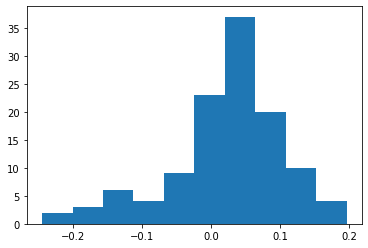

In [83]:
plt.hist(X['spy_close'])